# Vehicle Detection

## Import libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
import time
from scipy.ndimage.measurements import label
from skimage import img_as_ubyte
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Utility functions

In [2]:
def plot_image(image, title=''):
    """
    Plot an image.
    """
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

    
def plot_pipeline(pipeline, titles, rows=1, fontsize=20):
    """
    Plot images in the pipeline.
    """
    cols = int(float(len(pipeline)) / rows)
    
    if rows * cols != len(pipeline):
        print('{0} x {1} = {2}'.format(rows, cols, len(pipeline)))
    
    f, axs = plt.subplots(rows, cols, figsize=(20, 20))
    f.tight_layout()
    
    axs = axs.ravel()
    
    for i in range(len(pipeline)):
        cmap = 'jet'
        if titles[i] == 'Heatmap':
            cmap='hot'
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].imshow(pipeline[i], cmap=cmap)
        axs[i].set_title(titles[i], fontsize=fontsize)
    plt.tight_layout()
    plt.show()
    
def plot_images(image1, title1, cmap1, image2, title2, cmap2):
    """
    Plot two images side by side.
    """
    fig = plt.figure()
    plt.subplot(121)
    plt.xticks([])
    plt.yticks([])
    plt.title(title1)
    plt.imshow(image1, cmap=cmap1)
    plt.subplot(122)
    plt.xticks([])
    plt.yticks([])
    plt.title(title2)
    plt.imshow(image2, cmap=cmap2)
    plt.show()

## Classifier features

The followng cell includes functions used to extract features from images. **get_hog_features** computes the histogram of gradients of the input image. **bin_spatial**, instead, computes binned color features of the input image while **color_hist** computes the color histogram of the input image. All these functions are used by **extract_features** which, for each image, computes an array of features catenating all the features together. The final output of **extract_features** is a matrix whose rows are images and columns are features.

In [3]:
def get_hog_features(image, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    """
    Compute Histogram Of Gradients feature.
    """
    
    # If vis==True return both the features array and the HOG image
    if vis == True:
        features, hog_image = hog(image, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise just return features array
    else:      
        features = hog(image, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def bin_spatial(image, size=(16, 16)):
    """
    Compute binned color feature.
    """
    return cv2.resize(image, size).ravel() 


def color_hist(image, nbins=32, bins_range=(0, 256)):
    """
    Compute color histogram feature.
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))


def extract_features(images, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=9, pix_per_cell=8,
                        cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Compute selected features on a list of images.
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in images:
        file_features = []
        # Read in each image one by one
        image = mpimg.imread(file)
        # Make sure color values range is [0, 255]
        image = img_as_ubyte(image)
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Compute binned color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        # Compute color histogram features
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        # Compute HOG features
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def draw_boxes(image, bboxes, color=(0, 255, 0), thick=6):
    """
    Draw rectangular boxes on an image.
    """
    # Make a copy of the image
    image_copy = np.copy(image)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(image_copy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return image_copy

## Loading non-car sample images

In the following cell sample 'non-car' images are loaded in a list. The list will be used later to train the classifier to recognize 'non-car' images.

In [4]:
# List of 'non-car' image samples
non_cars = []
non_car_files = glob.glob('dataset/non-vehicles/*/*.png')
for filename in non_car_files:
    non_cars.append(filename)
len_non_cars = len(non_cars)

print('non cars len: {}'.format(len_non_cars))

non cars len: 9015


### Sample non car images

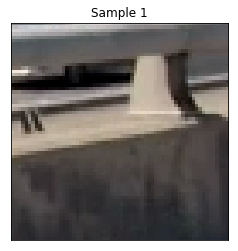

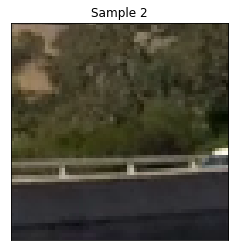

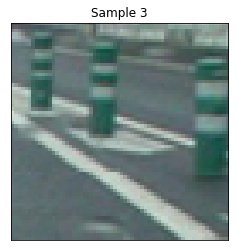

In [5]:
# Sample 'non-car' images
n_samples = 3
for sample in range(n_samples):
    i = np.random.randint(len_non_cars)
    image = mpimg.imread(non_cars[i])
    image = img_as_ubyte(image)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title('Sample {}'.format(sample+1))
    plt.show()
    mpimg.imsave('output_images/noncar{}.jpg'.format(sample+1), image)

## Loading car sample images

In the following cell sample 'car' images are loaded in a list. The list will be used later to train the classifier to recognize 'car' images.

In [6]:
# List of 'car' image samples
cars = []
car_files = glob.glob('dataset/vehicles/*/*.png')
for filename in car_files:
    cars.append(filename)
len_cars = len(cars)

print('cars len: {}'.format(len_cars))

cars len: 10074


### Sample car images

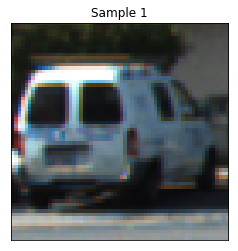

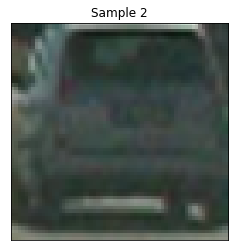

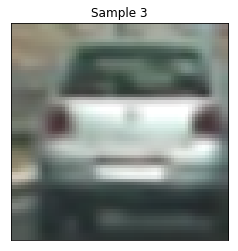

In [7]:
# Sample 'car' images
n_samples = 3
for sample in range(n_samples):
    i = np.random.randint(len_cars)
    image = mpimg.imread(cars[i])
    image = img_as_ubyte(image)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title('Sample {}'.format(sample+1))
    plt.show()
    mpimg.imsave('output_images/car{}.jpg'.format(sample+1), image)

## Sample HOG features

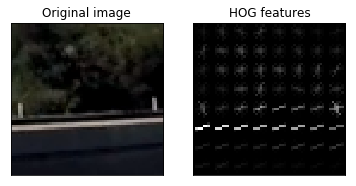

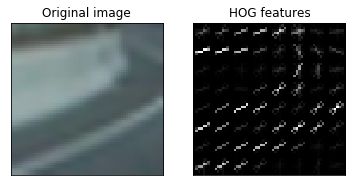

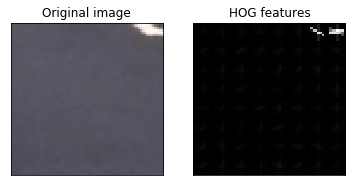

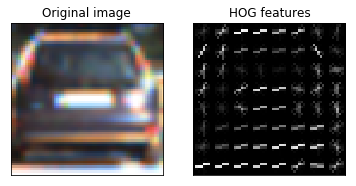

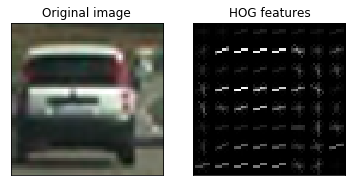

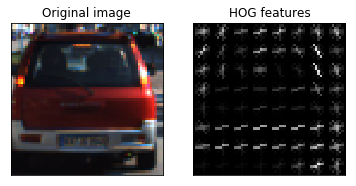

In [8]:
# Sample 'non-car' HOG features
n_samples = 3
for sample in range(n_samples):
    i = np.random.randint(len_non_cars)
    image = mpimg.imread(non_cars[i])
    image = img_as_ubyte(image)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(image_gray, orient=9, pix_per_cell=8,
        cell_per_block=2, vis=True, feature_vec=True)
    plot_images(image, 'Original image', 'jet', hog_image, 'HOG features', 'gray')
    mpimg.imsave('output_images/noncar_hog{}.jpg'.format(sample+1), hog_image, cmap='gray')

# Sample 'car' HOG features 
n_samples = 3
for sample in range(n_samples):
    i = np.random.randint(len_cars)
    image = mpimg.imread(cars[i])
    image = img_as_ubyte(image)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(image_gray, orient=9, pix_per_cell=8,
        cell_per_block=2, vis=True, feature_vec=True)
    plot_images(image, 'Original image', 'jet', hog_image, 'HOG features', 'gray')
    mpimg.imsave('output_images/car_hog{}.jpg'.format(sample+1), hog_image, cmap='gray')

## Parameters

The following cell includes the parameters used to extract features from images:
* **color_space**: the color space to which each image is converted before applying feature extraction
* **orient**: the number of bins used to extract HOG features
* **pix_per_cell**: the number of pixels, both vertical and horizontal, defining the size of a single cell used to extract HOG features
* **cell_per_block**: number of cells used to normalize the HOG features
* **hog_channels**: channels of the image used to compute the HOG features
* **spatial_feat**: flag activating binned color features extraction
* **hist_feat**: flag activating color histogram features extraction
* **hog_feat**: flag activating histogram of gradients features extraction

In [9]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Hog color channel (can be 0, 1, 2, or 'ALL')
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Color histogram features on or off
hog_feat = True # HOG features on or off

print('Parameters')
print('color space: {}'.format(color_space))
print('orientation: {}'.format(orient))
print('ixels_per_cell: {}'.format(pix_per_cell))
print('cells_per_block: {}'.format(cell_per_block))
print('hog_channel: {}'.format(hog_channel))
print('spatial_size: {}'.format(spatial_size))
print('hist_bins: {}'.format(hist_bins))
print('spatial_feat: {}'.format(spatial_feat))
print('hist_feat: {}'.format(hist_feat))
print('hog_feat: {}'.format(hist_feat))

Parameters
color space: YCrCb
orientation: 9
ixels_per_cell: 8
cells_per_block: 2
hog_channel: ALL
spatial_size: (16, 16)
hist_bins: 32
spatial_feat: True
hist_feat: True
hog_feat: True


## Extract car and non-car features

In the following cell the **features** are extracted for each image in the dataset. The dataset includes both 'car' and 'non-car' images. Once all features are computed we end up having a matrix X in which each row is an image (car / non-car) and each column is a feature. y, instead, is an array including the corresponding label for each row of the matrix X, 1 for cars and 0 for non-cars. Once feature extraction is complete we have a complete dataset represented as a matrix, X, and an array y, which we can use to feed different classifiers.

In [10]:
# Extract car features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Extract non car features
noncar_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# X (N x M matrix: N samples, M features)
X = np.vstack((car_features, noncar_features)).astype(np.float64)
# y (N elements array of labels)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (19089, 6156)
y shape: (19089,)


## Normalize features

Before training the classifier features are **normalized**. This way no feature or set of features dominates classification. If a feature or set of features, indeed, has greater magnitude with respect to other features, those features would dominate the classification of images. Here a **StandardScaler** is used to perform  normalization of the features.

In [11]:
# Scale the matrix of features (avoids a feature dominating the others)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X to normalize features
X = X_scaler.transform(X)
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (19089, 6156)
y shape: (19089,)


## Shuffle and Train/Test split

Before training the classifier we also **shuffle** the dataset to prevent patterns in the ordering of data to have a negatve impact on the training and classification performance of the classifier. Then we **split** the dataset into **training set** and **test set**. The training set is used by the classifier algorithm to tune its parameters and achive the highest possible accuracy. The test set will be used to verify the performances of the classifier on unseen data.

In [12]:
# Shuffle the dataset
X, y = shuffle(X, y)
# Split the dataset into training (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=17)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (15271, 6156)
y_train shape: (15271,)
X_test shape: (3818, 6156)
y_test shape: (3818,)


## Classifier training

A **Linear Support Vector Machine** is trained on the training set. Once done the classifier can distinguish images representing cars and images which do not represet cars. Once we have such classifier we can extract pieces of an image coming from the camera and predict each piece as car / non-car. This means we can use the classifier on input images coming from the camera to identify cars and their position.

In [13]:
print('Feature vector length: {}'.format(X_train.shape[1]))
# Use a SVC 
clf = LinearSVC()
# Measure the training time for the classifier
t_start = time.time()
clf.fit(X_train, y_train)
t_end = time.time()
print('Classifier training time: {}'.format(round(t_end - t_start, 2)))
# Check the accuracy score of the classifier
print('Classifier test set accuracy: {}'.format(round(clf.score(X_test, y_test), 4)))

Feature vector length: 6156
Classifier training time: 20.65
Classifier test set accuracy: 0.9919


In [14]:
# Free some memory (after training the classifier the dataset in not needed)
X, y = [], []
X_train, X_test, y_train, y_test = [], [], [], []

## Load a test image

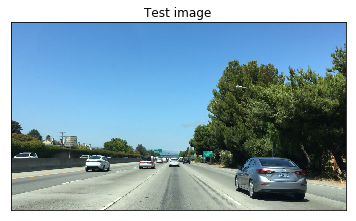

In [15]:
# Load and show a test image
image = mpimg.imread('test_images/test7.jpg')
image = img_as_ubyte(image)
plot_image(image, title='Test image')

## Finding cars in input images

The function **find_cars** is used to identify cars in an input image. The image is 'split' in mupltiple sub-images, for each sub-image the features are extracted the same way it has been done while training the classifier. Once features are extracted, for each sub-image we feed the classifier with these features and predict if the sub-image is a car or not. If the sub-image is a car we identify such sub-image and its bounding box as a box containing a car.

In [16]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Convert an image to a specific colorspace.
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    """
    Find boxes including cars in an image.
    """
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 is the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # List of bounding boxes predicted to include a car
    on_windows = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (16,16))
          
            # Get the binned color feature
            spatial_features = bin_spatial(subimg, size=spatial_size)
            
            # Get the color histogram feature
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            # Compute the distance of the patch from the decision boundary
            # (used later to decide on car/non-car to improve robustness against False Positives)
            margin = svc.decision_function(test_features)
            
            # If the patch is predicted to include a car and its distance from the decision boundary is above
            # a threshold then predict this patch to include a car
            if test_prediction == 1 and margin > 0.35:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # Append the currect box to the boxes including a car
                on_windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
    
    # Return all the boxes predicted to include a car
    return on_windows

### Sample multiple scale car searching

In the following cell the previous **find_cars** function is used to search cars in a sample image *using different scales*. Using multiple scales allows us to divide the original image in sub-images of different sizes. This is necessary since, depending on weather cars are close or far, they appear small or large. This makes the detection algorithm **invariant** to the size of cars it can detect. At the end the variable *hot_windows* will include a list of windows which are predicted to contain a car. Those windows will likely **overlap** each other or even not include a car as a result of a **false positive** detection of the classifier. For this reason, further processing of this list of windows is required to collapse overlapping windows into a single window and to get rid of false positive detections.

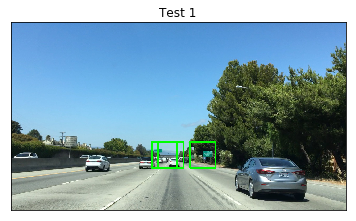

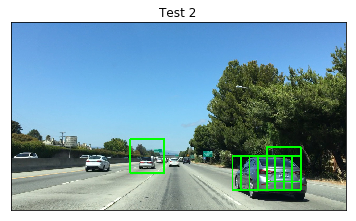

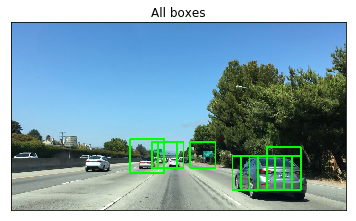

In [17]:
# find_cars is called on two regions of interest to identify cars at different scales
hot_windows1 = find_cars(image, 380, 580, 1.50, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
hot_windows2 = find_cars(image, 440, 680, 2.00, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# Group all hot windows in a single list
hot_windows = hot_windows1 + hot_windows2

boxes_img = draw_boxes(image, hot_windows1)
plot_image(boxes_img, 'Test 1')
mpimg.imsave('output_images/test1.jpg', boxes_img)

boxes_img = draw_boxes(image, hot_windows2)
plot_image(boxes_img, 'Test 2')
mpimg.imsave('output_images/test2.jpg', boxes_img)

boxes_img = draw_boxes(image, hot_windows)
plot_image(boxes_img, 'All boxes')
mpimg.imsave('output_images/test_all_boxes.jpg', boxes_img)

## Removing overlapping windows and false positive detections

To remove **overlapping** windows and windows representing **false positive** detections a **heat map** is built. The idea is to create a blank image and to add '+1' to each pixel in the image which is inside one of the *hot_windows* identified before. Once we have such hot map, a **threshold** is applied filtering out all the pixels whose value is smaller or equal to the threshold value. The result is that pixels included in multiple overlapping windows will get higher values and likely not being filtered out. While, false positive detections, will have lower values and will be filtered out by the threshold. Tuning of the threshold parameter is required, anyway.

In [18]:
def add_heat(heatmap, bbox_list, heat_value):
    """
    Create a heatmap adding 'heat_value' every time a pixel of the image is inside a box.
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += heat_value for all pixels inside each bbox
        # Assuming each 'box' takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += heat_value
    return heatmap


def heatmap_threshold(heatmap, threshold):
    """
    Filter out pixels of the heat map whose value is lower or equal to a certain threshold.
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return np.clip(heatmap, 0, 255)


def heatmap(image, windows):
    """
    Compute a heat map of the input image.
    """
    # Add heat to each box in box list
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, windows, 1)
    
    return heatmap


def draw_labeled_bboxes(image, labels, color=(0, 255, 0), tickness=6):
    """
    Label boxes including car images given a heat map.
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the bounding box on the image
        cv2.rectangle(image, bbox[0], bbox[1], color, tickness)
    return image

### Full pipeline on sample images

In the following cell the full pipeline is tested on sample input images. The first image in each row represents the input image, the second image shows all the bounding boxes identified by calling **find_cars** multiple times at different scales. The third image shows the heat map used to collapse overlapping windows and  filter out outliers. The fourth image in each row shows a bounding box around each identified car.

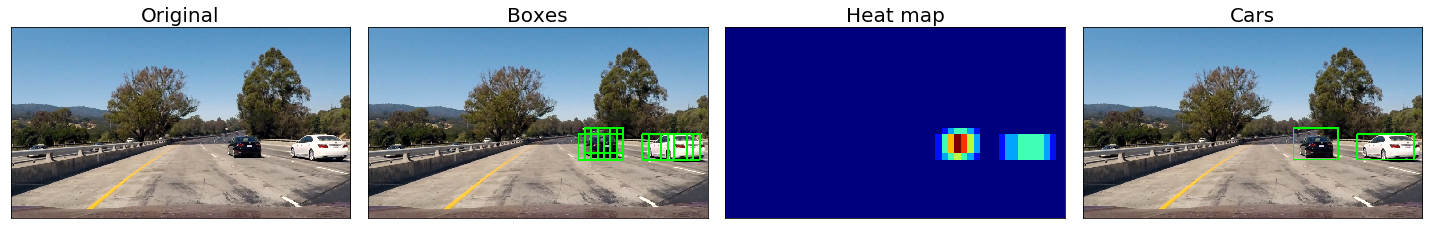

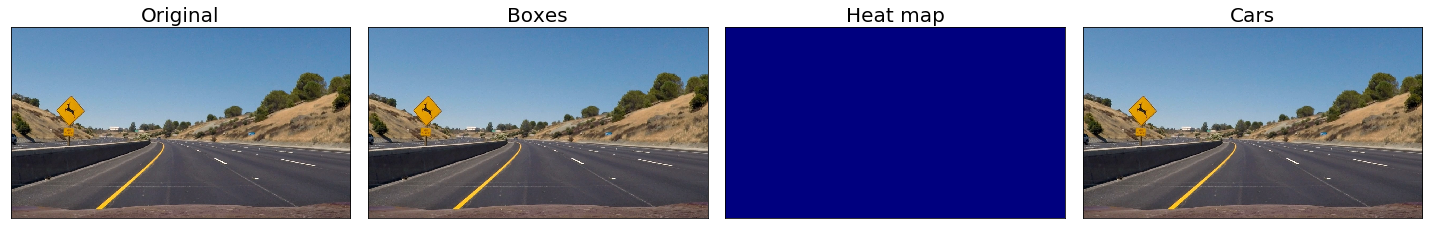

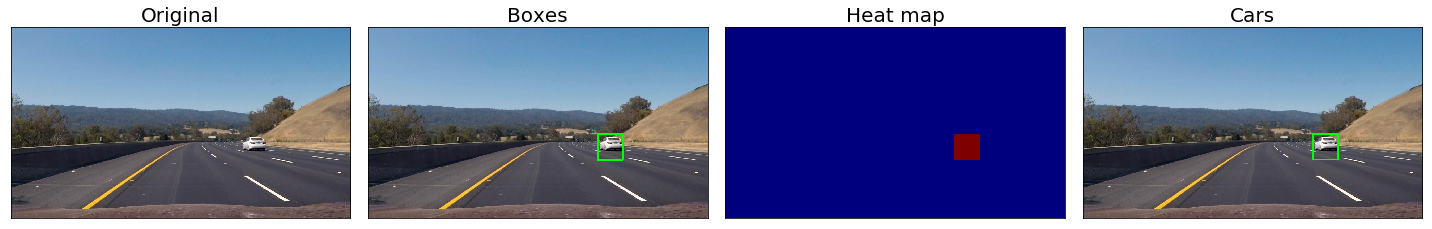

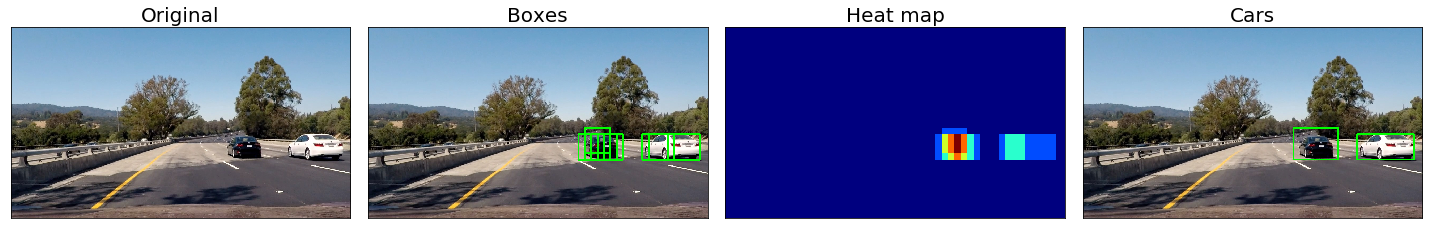

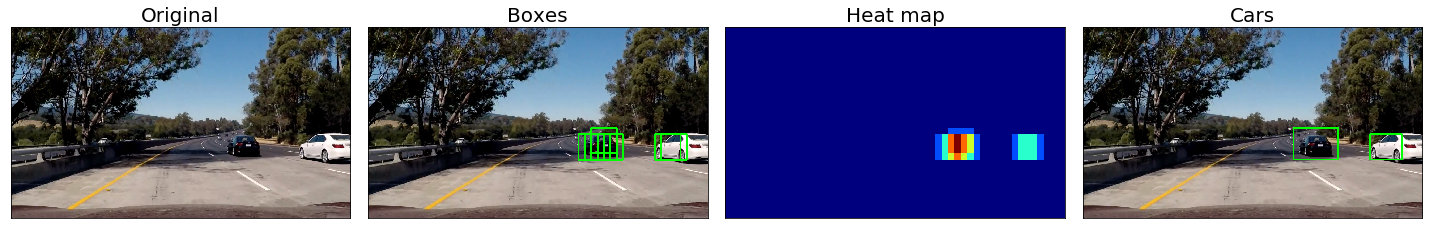

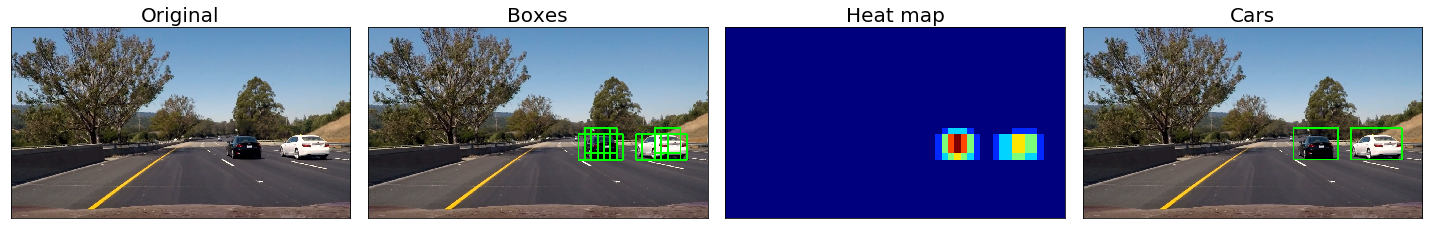

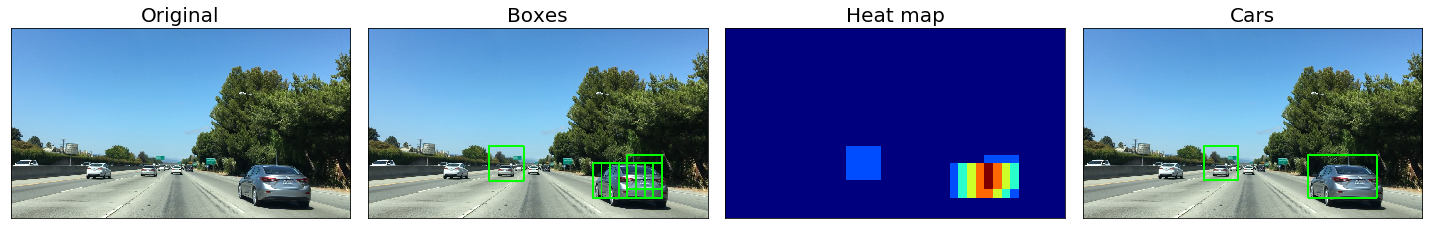

In [19]:
test_images = glob.glob('test_images/*.jpg')
count = 0
for filename in test_images:
    image = mpimg.imread(filename)
    image = img_as_ubyte(image)
    hot_windows1 = find_cars(image, 380, 540, 1.50, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    hot_windows2 = find_cars(image, 440, 680, 2.00, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Group all hot windows in a single list
    hot_windows = hot_windows1 + hot_windows2
    # Draw all boxes on the original image
    boxes_img = draw_boxes(image, hot_windows)
    # Create a heat map out of all hot windows    
    heat_img = heatmap(image, hot_windows)
    # Find final boxes from heat map using label function
    labels = label(heat_img)
    # Draw a single box around each car
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    # Show the full processing pipeline
    pipeline_images = [image, boxes_img, heat_img, draw_img]
    pipeline_titles = ['Original', 'Boxes', 'Heat map', 'Cars']
    plot_pipeline(pipeline_images, pipeline_titles)

## Pipeline function

The following cell provides the **pipeline** function which applies all the processing to single images. The pipeline function does the following:
1. Applies **find_cars** two times at different scales identifying boxes including cars
2. Builds a heat map used to collapse overlapping windows and filter out false positive classifications
3. Labels the heat map to identify each car in the input image
4. Draws a bounding box around each car in the image

In [20]:
import random
# List of heat maps
heat_images = []
def pipeline(image):
    image = img_as_ubyte(image)
    hot_windows1 = find_cars(image, 360, 540, 1.50, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    hot_windows2 = find_cars(image, 440, 680, 2.00, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Group all hot windows in a single list
    hot_windows = hot_windows1 + hot_windows2
    
    # Create a heat map    
    heat_img = heatmap(image, hot_windows)
    
    # Create an empty heat map
    heat_map = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Keep the last 18 heat maps
    heat_images.append(heat_img)
    if len(heat_images) > 12:
        del heat_images[:1]
    # Compute a single heat map out of all the stored heat maps
    for heat_image in heat_images:
        heat_map += heat_image
    
    # Apply threshold to the heat map
    heat_map = heatmap_threshold(heat_map, threshold=10)
    
    # Label cars
    labels = label(heat_map)
    
    return draw_labeled_bboxes(np.copy(image), labels)

## Process video

In [21]:
# Process the test video
heat_images = []
video_output = 'test_video_output.mp4'
clip1 = VideoFileClip('test_video.mp4')
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:19<00:00,  2.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 21 s


In [22]:
# Process the project video
heat_images = []
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [09:05<00:00,  2.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 9min 6s
